# Titanic: EDA, model comparison and tuning

# Table of contents

1. [Introduction](#1.-Introduction)
2. [Import data](#2.-Import-data)
3. [Exploratory data analysis](#3.-Exploratory-data-analysis)
4. [Feature engineering](#4.-Feature-engineering)
5. [Model selection and tuning](#5.-Model-selection-and-tuning)
6. [Conclusions and further developments](#6.-Conclusions-and-further-developments)
7. [Acknowledgements](#7.-Acknowledgements)

# 1. Introduction

The objective of the Kaggle competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) is to develop machine learning models to predict which passengers survived the shipwreck. This type of machine learning is called [classification](https://en.wikipedia.org/wiki/Statistical_classification). More specifically, since there are only two different states we are classifying (survived or not survived), it is called [binary classification](https://en.wikipedia.org/wiki/Binary_classification).

This notebook focus on exploratory data analysis, feature engineering, and model selection and hyperparameter tuning. If you have further ideas to improve this notebook or anything you don’t understand, please leave a comment.

# 2. Import data

In [1]:
%reset -f

# Import modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import sys
from utils import *

mpl.rcParams.update({'font.size': 13})
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=wong_colors.values())

print('Python version', sys.version.split()[0])

Python version 3.8.7


In [2]:
# Import training and test sets
folder = './'
# folder = '/kaggle/input/titanic/'

train = pd.read_csv(folder + 'train.csv')
test = pd.read_csv(folder + 'test.csv')

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

# Convert columns names to lowercase
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

Training set shape: (891, 12)
Test set shape: (418, 11)


In [3]:
train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The columns of this DataFrame are:

* `passengerid` - Unique identifier of each passenger (used for submissions).
* `survived` - Whether the passenger survived or not (0=No, 1=Yes).
* `pclass` - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd).
* `name` - Name of the passenger.
* `sex` - The passenger's sex.
* `age` - The passenger's age in years.
* `sibsp` - The number of siblings or spouses the passenger had aboard the Titanic.
* `parch` - The number of parents or children the passenger had aboard the Titanic.
* `ticket` - The passenger's ticket number.
* `fare` - The fare the passenger paid.
* `cabin` - The passenger's cabin number.
* `embarked` - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton).

Both sets have 11 features. The extra column of the training set is the target variable `survived`.

# 3. Exploratory data analysis

Now let’s look at the columns’ data types and the number of missing values.

In [4]:
pd.concat([train, test]).describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


We can see that:

* Only 38.4% of the passengers survived;
* The age ranges from 0.17 to 80;
* Some columns have missing values (missing values of column `survived` are from the test set).

In [5]:
df_info(train)

,Null count,Dtype
passengerid,0,int64
survived,0,int64
pclass,0,int64
name,0,object
sex,0,object
age,177,float64
sibsp,0,int64
parch,0,int64
ticket,0,object
fare,0,float64


In [6]:
df_info(test)

,Null count,Dtype
passengerid,0,int64
pclass,0,int64
name,0,object
sex,0,object
age,86,float64
sibsp,0,int64
parch,0,int64
ticket,0,object
fare,1,float64
cabin,327,object


The columns' data types seem to be correct, but we need to convert some features so that machine learning algorithms can process them. The following columns have missing values:

* `age` and `cabin` of both datasets
* `embarked` of the training set
* `fare` of the test set

The passengers that do not have the port where they embarked are:

In [7]:
df = train.sort_values('ticket', ignore_index=True)
df.loc[df['embarked'].isnull()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
39,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
40,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


They both have the same ticket. Let’s see how many passengers have that ticket.

In [8]:
(df['ticket'] == '113572').sum()

2

No other passenger shares that ticket. Now let’s see where other passengers with similar tickets embarked:

In [9]:
df.loc[40:80, 'embarked'].value_counts()

S    36
C     4
Name: embarked, dtype: int64

Most of them embarked at Southampton, and so we will use that value.

In [10]:
train.loc[train['embarked'].isnull(), 'embarked'] = 'S'

Regarding the missing fare value, we will assign the mean value.

In [11]:
test.loc[test['fare'].isnull(), 'fare'] = test['fare'].mean()

The columns `age` and `cabin` have too many missing values and will not be used. Now let's plot our data.

In [12]:
def plot_discrete_feature(train, feature):

    survived = train.groupby(feature)['survived'].mean() * 100
    x = range(len(survived))

    _, axs = plt.subplots(1, 2, figsize=(14,5))

    plt.sca(axs[0])
    plt.bar(x, train.groupby(feature)['survived'].size())
    plt.ylabel('N. of passengers')

    plt.sca(axs[1])
    plt.bar(x, survived)
    plt.bar(x, 100 - survived, bottom=survived)
    plt.ylabel('Survival percentage')
    plt.legend(['Survived', 'Not survived'], loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    
    for ax in axs:
        set_spines_vis(ax=ax)      
        ax.set_xticks(x)
        ax.set_xticklabels(survived.index)
        ax.set_xlabel(feature)

In [13]:
def plot_continuous_feature(train, feature, binwidth):

    plt.figure(figsize=(10,5))
    sns.histplot(train, x=feature, hue='survived', binwidth=binwidth, legend=False)
    plt.legend(['Survived', 'Not survived'], frameon=False)
    set_spines_vis()

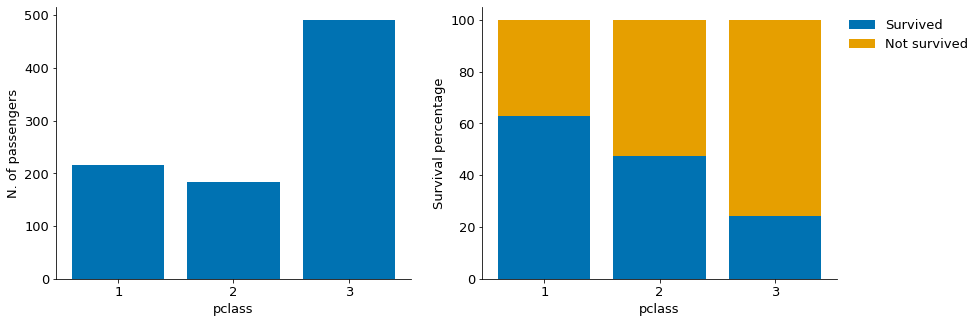

In [14]:
plot_discrete_feature(train, 'pclass')

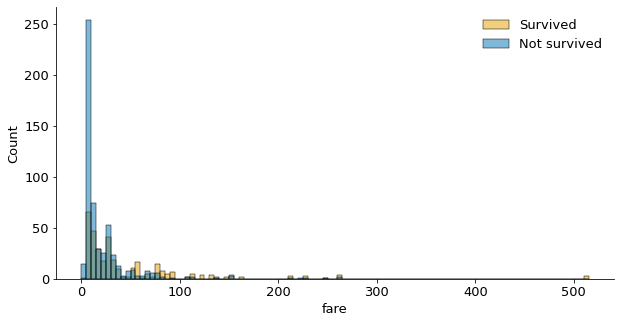

In [15]:
plot_continuous_feature(train, 'fare', 5)

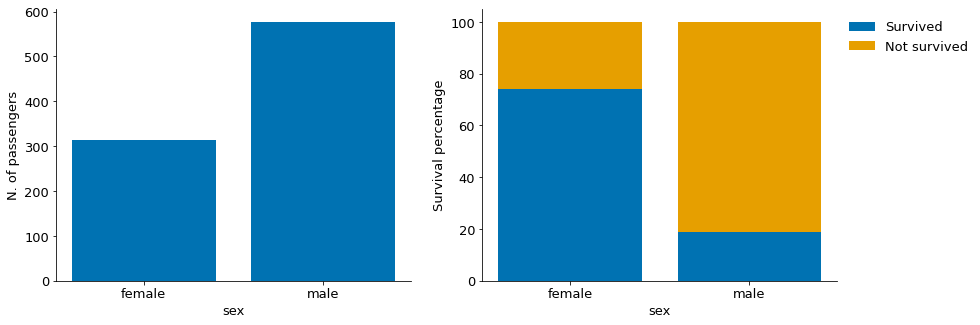

In [16]:
plot_discrete_feature(train, 'sex')

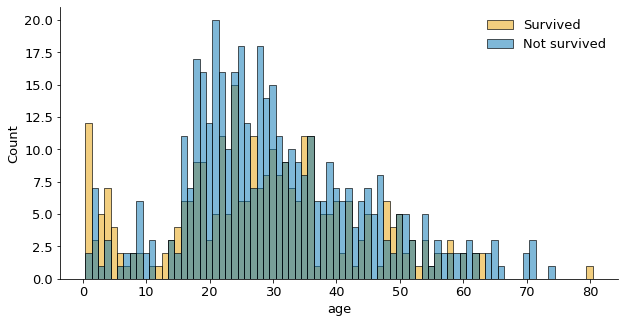

In [17]:
plot_continuous_feature(train, 'age', 1)

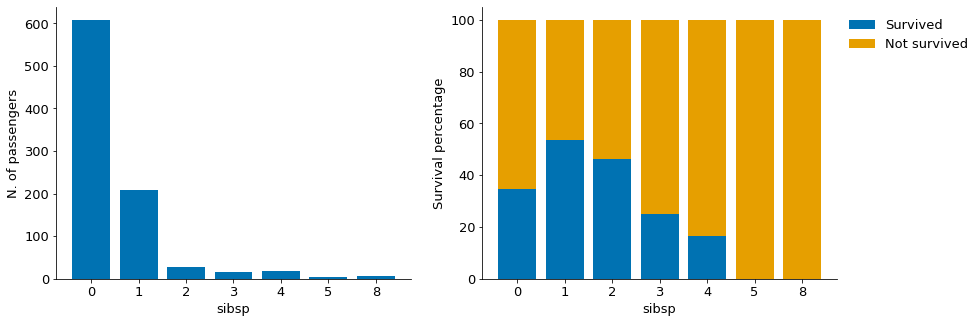

In [18]:
plot_discrete_feature(train, 'sibsp')

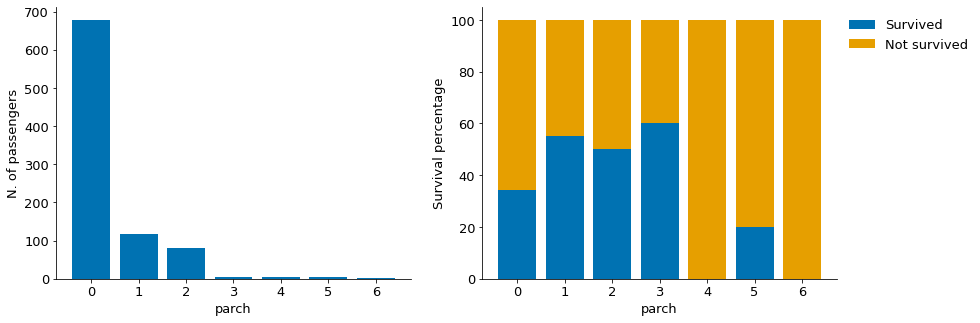

In [19]:
plot_discrete_feature(train, 'parch')

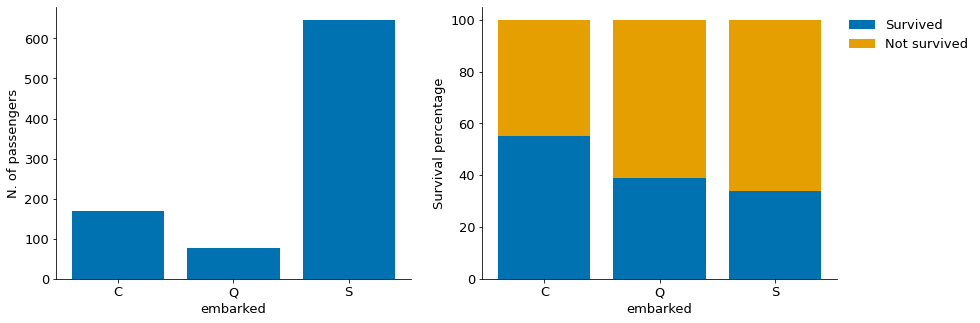

In [20]:
plot_discrete_feature(train, 'embarked')

We can observe that:

* Passengers with upper-class tickets had better chances of survival than the rest;
* Females survived in much higher proportion than males;
* People younger than five had more chances of surviving, while the rest did not;
* Passengers with no family members or with a lot of members have fewer chances of surviving;
* Passengers with lower fares had worse chances of survival;
* The port where the passenger embarked seems to influence the chances of survival.

The fare seems to capture the same information as the ticket class, and hence it will not be used. The columns `pclass`, `sex` and `embarked` are categorical features. Although the column `pclass` is numeric, there is not a numeric relationship between the different values. For instance, class 3 is not the triple of class 1. Most machine learning algorithms cannot understand text labels, and so we have to convert our values into numbers. The pandas function [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) turns each categorical feature into a series of zeros and ones.

In [21]:
def get_dummies(train, test, columns):

    # Concatenate training and test sets
    df = pd.concat([train[columns], test[columns]])

    # Convert categorical variables into dummy variables
    df = pd.get_dummies(df)

    X_train = df.iloc[:train.shape[0]]
    X_test = df.iloc[train.shape[0]:]

    return X_train, X_test

In [22]:
train['pclass'] = train['pclass'].astype('category')
test['pclass'] = test['pclass'].astype('category')

features = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
X_train, X_test = get_dummies(train, test, features)

y_train = train['survived']

We will start by using the Scikit-learn [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class to predict if the passengers survived or not. We can’t use the test set to evaluate the accuracy of our model because it does not have the column `survived`. We would need to submit to Kaggle every time we wanted to assess the accuracy of the predictions. We could also fit and predict using the entire training dataset, but this would likely overestimate the accuracy since our model would perform worse on unseen data. Instead, we can use cross-validation techniques to train and test our model on different splits of our data and then average the accuracy scores. We will use the [k-fold cross-validation method](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation), in which the original sample is randomly partitioned into *k* equal sized subsamples. Of the *k* subsamples, a single subsample is retained as the validation data, and the remaining *k* − 1 subsamples are used as training data. The cross-validation process is then repeated *k* times, with each of the *k* subsamples used exactly once as the validation data. The *k* results can then be averaged to produce a single estimation. We will use the utility function **sklearn_fit_eval** with a 5-fold cross validation.

In [23]:
lr = LogisticRegression(max_iter=1000)

sklearn_fit_eval(lr, {'X':X_train, 'y':y_train}, cv=5);

Train accuracy: 79.24%; Validation accuracy: 78.90%; Fitting time: 0.03s


The validation accuracy (78.90%) is lower than the training accuracy (79.24%), which might mean the model is overfitting. We will deal with the overfitting in section [Model selection and hyperparameter tuning](#Model-selection-and-hyperparameter-tuning). Now let’s calculate the predictions for the test set.

In [24]:
def save_submission(y, passenger, filename):
    submission = pd.DataFrame({'PassengerId':passenger,'Survived':y})
    submission.to_csv(filename, index=False)

save_submission(lr.predict(X_test), test['passengerid'], 'submission_1.csv')

The test set predictions were submitted to Kaggle, and an accuracy of 76.79% was obtained.

# 4. Feature engineering

Feature engineering is the process of transforming raw data into features that better represent the underlying problem and enable more accurate predictive models. One common way to engineer a feature is using a technique called binning. Binning is when you take a continuous feature, like the age, and separate it into several ranges (or 'bins'), turning it into a categorical variable. This can be useful when there are patterns in the data that are nonlinear and you're using a linear model like logistic regression. Let’s group the `age` column into the following age groups:

Age group | Age interval
--- | ---
Infant | 0-5
Child  | 5-12
Teenager | 12-18
Adult | 18-60
Senior | 60+

In [25]:
def group_age(age):

    age = age.fillna(-0.5)

    bins = [-1, 0, 5, 12, 18, 35, 60, 150]
    labels = ['Missing', 'Infant', 'Child', 'Teenager', 'Young adult', 'Adult', 'Senior']

    return pd.cut(age, bins, labels=labels)

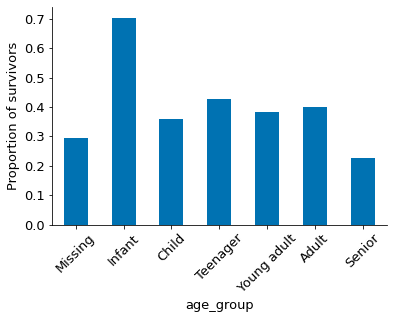

In [26]:
train['age_group'] = group_age(train['age'])
test['age_group'] = group_age(test['age'])

train.groupby('age_group')['survived'].mean().plot.bar(rot=45, ylabel='Proportion of survivors')
set_spines_vis()

Another way to engineer features is by extracting data from text columns. Let's look at a random sample of the column `name`.

In [27]:
train['name'].sample(10)

87                 Slocovski, Mr. Selman Francis
168                          Baumann, Mr. John D
153              van Billiard, Mr. Austin Blyler
725                          Oreskovic, Mr. Luka
781    Dick, Mrs. Albert Adrian (Vera Gillespie)
739                           Nankoff, Mr. Minko
811                            Lester, Mr. James
825                              Flynn, Mr. John
853                    Lines, Miss. Mary Conover
406             Widegren, Mr. Carl/Charles Peter
Name: name, dtype: object

The title of each name might be useful information. We will create a new column with this.

In [28]:
titles = train['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

We have too many unique values, which might lead to overfitting. We will group these titles into the categories `Mr`, `Mrs`, `Master`, `Miss`, `Officer` and `Royalty`.

In [29]:
titles_map = {
    'Mr' :         'Mr',
    'Mme':         'Mrs',
    'Ms':          'Mrs',
    'Mrs' :        'Mrs',
    'Master' :     'Master',
    'Mlle':        'Miss',
    'Miss' :       'Miss',
    'Capt':        'Officer',
    'Col':         'Officer',
    'Major':       'Officer',
    'Dr':          'Officer',
    'Rev':         'Officer',
    'Jonkheer':    'Royalty',
    'Don':         'Royalty',
    'Sir' :        'Royalty',
    'Countess':    'Royalty',
    'Dona':        'Royalty',
    'Lady' :       'Royalty'
}

def extract_title(names):
    '''Extracts the title from the passenger names.'''

    return names.str.extract(' ([A-Za-z]+)\.', expand=False).map(titles_map)

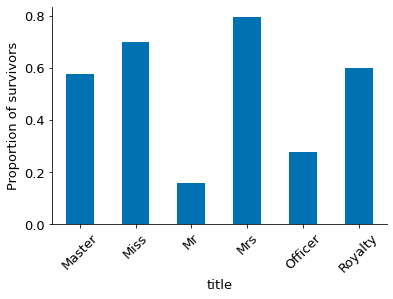

In [30]:
train['title'] = extract_title(train['name'])
test['title'] = extract_title(test['name'])

train.groupby('title')['survived'].mean().plot.bar(rot=45, ylabel='Proportion of survivors')
set_spines_vis()

Let's calculate our model's accuracy with the column `age` grouped in bins and the additional feature `title`.

In [31]:
features = ['pclass', 'sex', 'sibsp', 'parch', 'embarked', 'age_group', 'title']
X_train, X_test = get_dummies(train, test, features)

sklearn_fit_eval(lr, {'X':X_train, 'y':y_train}, cv=5);

Train accuracy: 83.05%; Validation accuracy: 82.38%; Fitting time: 0.04s


The validation accuracy increased from 78.90% to 82.38%. Now we will predict which passengers of the test set survived.

In [32]:
save_submission(lr.predict(X_test), test['passengerid'], 'submission_2.csv')

The test set predictions were submitted to Kaggle, and an accuracy of 78.95% was obtained.

# 5. Model selection and tuning

We can also try different machine learning models to improve performance. Each algorithm has different strengths and weaknesses, and so we need to select the algorithm that works best with our specific data. We will use the Scikit-learn library to compare the performance of the following algorithms:

* [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) - Logistic regression classifier.
* [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) - Decision tree classifier.
* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) - Random forest classifier.
* [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) - Neural network classifier.

In [33]:
models = {
    'Logistic regression':LogisticRegression(max_iter=1000),
    'Decision tree':DecisionTreeClassifier(random_state=0),
    'Random forest':RandomForestClassifier(random_state=0),
    'Neural network':MLPClassifier(max_iter=1000, random_state=0)
}

fit_params = {'X':X_train, 'y':y_train}

for k, v in models.items():
    
    print('{:>19}; '.format(k), end='')
    sklearn_fit_eval(v, fit_params, cv=5);

Logistic regression; Train accuracy: 83.05%; Validation accuracy: 82.38%; Fitting time: 0.06s
      Decision tree; Train accuracy: 87.65%; Validation accuracy: 78.79%; Fitting time: 0.01s
      Random forest; Train accuracy: 87.65%; Validation accuracy: 79.69%; Fitting time: 0.35s
     Neural network; Train accuracy: 87.21%; Validation accuracy: 79.80%; Fitting time: 4.42s


The logistic regression model has the highest validation accuracy. Now let’s optimise the hyperparameters of each model. The utility function **plot_models_metrics** is used to compare the training and validation accuracies and training times. Although we tunned several hyperparameters for each model, only those that led to a considerable improvement are shown. We will start with the hyperparameter that controls the regularisation of the logistic regression model.

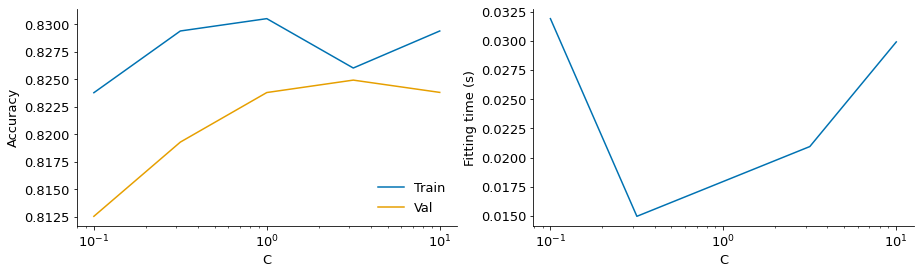

In [34]:
create_params = {'max_iter': 1000, 'C': np.logspace(-1, 1, 5)}
fit_eval_params = {'fit_params': fit_params, 'cv': 5, 'verbose': False}

plot_models_metrics(LogisticRegression, create_params, sklearn_fit_eval, fit_eval_params, axes_params={'xscale': 'log'})

In [35]:
create_params['C'] = 10**0.5
models['Logistic regression'] = LogisticRegression(**create_params)

Regarding the decision tree and random forest classifiers, we decided to tune the tree's maximum depth.

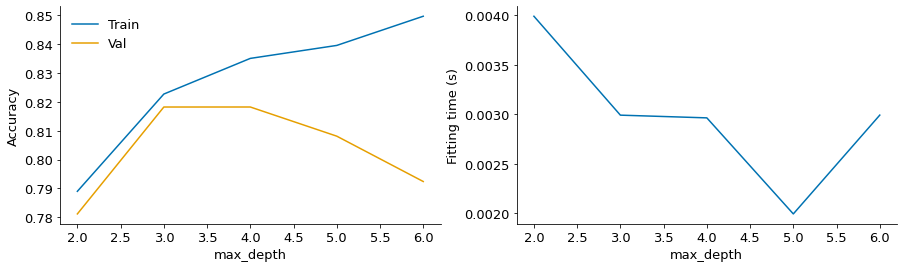

In [36]:
create_params = {'random_state': 0, 'max_depth': np.arange(2, 7)}

plot_models_metrics(DecisionTreeClassifier, create_params, sklearn_fit_eval, fit_eval_params)

In [37]:
create_params['max_depth'] = 3
models['Decision tree'] = DecisionTreeClassifier(**create_params)

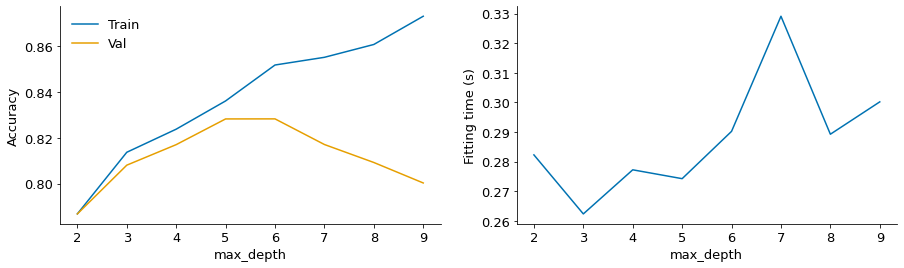

In [38]:
create_params = {'random_state': 0, 'max_depth': np.arange(2, 10)}

plot_models_metrics(RandomForestClassifier, create_params, sklearn_fit_eval, fit_eval_params)

In [39]:
create_params['max_depth'] = 5
models['Random forest'] = RandomForestClassifier(**create_params)

Now let's tune the hyperparameters of the neural network. We will start with the learning rate and minibatches' size. The utility function **sklearn_plot_losses** is used to compare the loss curves.

Value: 0.00010; Loss: 0.38; Fitting time: 3.19s
Value: 0.00046; Loss: 0.33; Fitting time: 2.96s
Value: 0.00215; Loss: 0.30; Fitting time: 1.71s
Value: 0.01000; Loss: 0.30; Fitting time: 0.58s


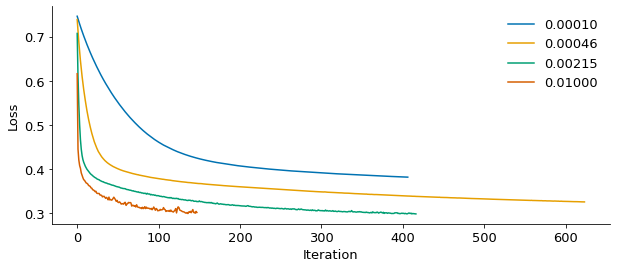

In [40]:
# Tune the initial learning rate
vals = list(np.logspace(-4, -2, 4))
create_params = {'max_iter':1000, 'random_state':0, 'learning_rate_init':vals}

sklearn_plot_losses(MLPClassifier, create_params, fit_params, ['{:.5f}'.format(val) for val in vals])

Value: 128; Loss: 0.30; Fitting time: 1.50s
Value: 256; Loss: 0.30; Fitting time: 1.49s
Value: 512; Loss: 0.30; Fitting time: 1.74s


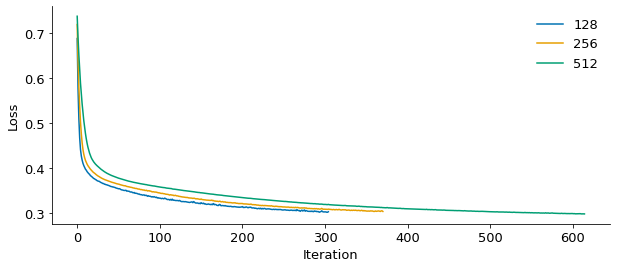

In [41]:
create_params['learning_rate_init'] = 0.002

# Tune the batch size
create_params['batch_size'] = [128, 256, 512]

sklearn_plot_losses(MLPClassifier, create_params, fit_params)

In [42]:
create_params['batch_size'] = 256

The model converges faster when using a learning rate of 0.01, but the loss curve is not smooth. A value of 0.00215 will be used instead. A similar approach is used for the minibatches' size. Now let’s tune the number of units of our hidden layer and regularization used.

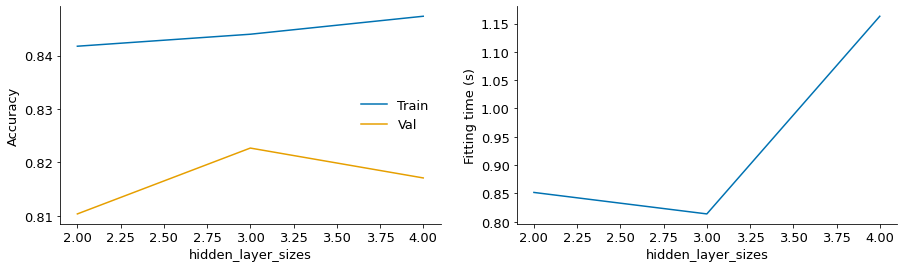

In [43]:
create_params['hidden_layer_sizes'] = list(range(2, 5))
fit_eval_params = {'fit_params': fit_params, 'cv': 5, 'verbose': False}

plot_models_metrics(MLPClassifier, create_params, sklearn_fit_eval, fit_eval_params)

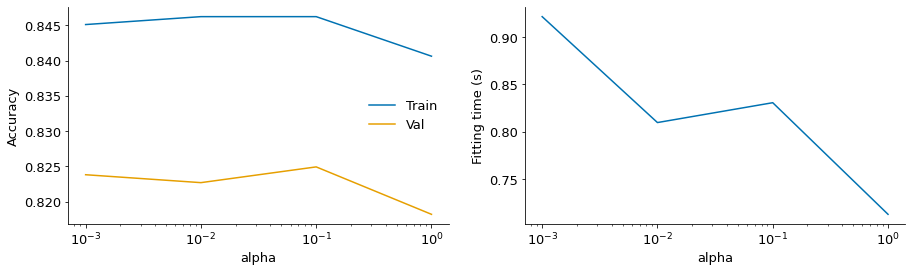

In [44]:
create_params['hidden_layer_sizes'] = 3
create_params['alpha'] = list(np.logspace(-3, 0, 4))

plot_models_metrics(MLPClassifier, create_params, sklearn_fit_eval, fit_eval_params, axes_params={'xscale': 'log'})

In [45]:
create_params['alpha'] = 0.1
models['Neural network'] = MLPClassifier(**create_params)

We can also use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) of the Scikit-learn library to tune the hyperparameters. Instead of varying each hyperparameter each time, this class tries all combinations of values.

In [46]:
%%time

grid_params = {
    'hidden_layer_sizes': range(2, 5),
    'alpha': np.logspace(-3, 0, 4)
}

grid = GridSearchCV(MLPClassifier(learning_rate_init=0.002, batch_size=256, max_iter=1000, random_state=0), grid_params, cv=5)
grid.fit(**fit_params)

print('Best accuracy: {:.2f}%'.format(grid.best_score_*100))
print('Best parameters: {}'.format(grid.best_params_))

Best accuracy: 82.49%
Best parameters: {'alpha': 0.1, 'hidden_layer_sizes': 3}
Wall time: 53.2 s


This method was much more computationally expensive and led to the same values. Nevertheless, it is always a good method to use when we have the computational power and want to get the most optimised results. It is good practice to use the utility functions to perform a coarser search and the class GridSearchCV to refine the results. We will now fit and evaluate the models with the optimised hyperparameters.

In [47]:
for k, v in models.items():
    
    print('{:>19}; '.format(k), end='')
    sklearn_fit_eval(v, fit_params, cv=5);

Logistic regression; Train accuracy: 82.60%; Validation accuracy: 82.49%; Fitting time: 0.11s
      Decision tree; Train accuracy: 82.27%; Validation accuracy: 81.82%; Fitting time: 0.01s
      Random forest; Train accuracy: 83.61%; Validation accuracy: 82.83%; Fitting time: 0.30s
     Neural network; Train accuracy: 84.62%; Validation accuracy: 82.49%; Fitting time: 0.84s


The random forest had the highest validation accuracy (82.83%). Now we will predict which passengers of the test set survived.

In [48]:
save_submission(models['Random forest'].predict(X_test), test['passengerid'], 'submission_3.csv')

The test set predictions were submitted to Kaggle, and an accuracy of 78.23% was obtained. Although the validation accuracy increased, the test accuracy decreased. The validation and test sets might have different distributions.

We can try to improve our models by using ensemble techniques. These techniques involve making a prediction that is the average of those obtained with different models. In classification, a hard voting ensemble involves summing the votes for all class labels and predicting the class with the most votes. A soft voting ensemble involves summing the predicted probabilities for class labels and predicting the class label with the largest sum probability. We will use soft voting.

In [49]:
prob = np.zeros((X_test.shape[0],2))

for model in models.values():
    
    prob += model.predict_proba(X_test)

y_test = prob.argmax(axis=1)

In [50]:
save_submission(y_test, test['passengerid'], 'submission_4.csv')

The test set predictions were submitted to Kaggle, and an accuracy of 78.71% was obtained.

# 6. Conclusions and further developments

This notebook uses machine learning models to predict which passengers survived the Titanic shipwreck. It explores how feature engineering, model selection, and hyperparameter optimization influences the accuracy of our model. The best model has a 78.95% test accuracy. To further improve our models, we can:

* Read more about the titanic and this Kaggle competition to get ideas for new features.
* Use different models such as support vector machines or gradient boosted trees.

Also, there are several other excellent notebooks related to this competition. Thanks for reading my notebook and any comments and suggestions are very welcome.

# 7. Acknowledgements

These excellent references inspired some of the code used in this notebook:
* [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions) by Manav Sehgal
* [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial) by Gunes Evitan
* [How am I doing with my score?](https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score/report) by Oscar Takeshita
* [Predicting the Survival of Titanic Passengers](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8) by Niklas Donges